# Visualize training of Beta VAE on circle/Gaussian data


### training parameters
- Input: circles on Gaussian-blob background (32x32)

- Number of latents: 10

- batch size: 64

- 500K training samples
- RMSprop w lr = 1e-04

- loss: MSE loss


Beta VAE:
- six different normalized beta Values (spacing of sampling roughly corresponding to Higgins 2017 y-axis):


``` normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e) ```


In [26]:
import torch
import pickle
from models import staticVAE32, beta_from_normalized_beta

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesb import dSpriteBackgroundDataset

In [28]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']


In [29]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = 'trained/staticvae32_nlatent=10_betanorm=%s_dsprites_circle_last_500K' % (beta_norm_str)
    trainstatspath = 'trained/staticvae32_nlatent=10_betanorm=%s_dsprites_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(staticVAE32(n_latent = 10))
    checkpoint = torch.load(trainedpath)
    vae[ii].load_state_dict(checkpoint['model_states']['net'])

    training_stats.append(pickle.load(open(trainstatspath, 'rb')))

### plot training loss

Three different plots:

- loss = recon_loss + beta * kl_div
- recon_loss
- kl_div

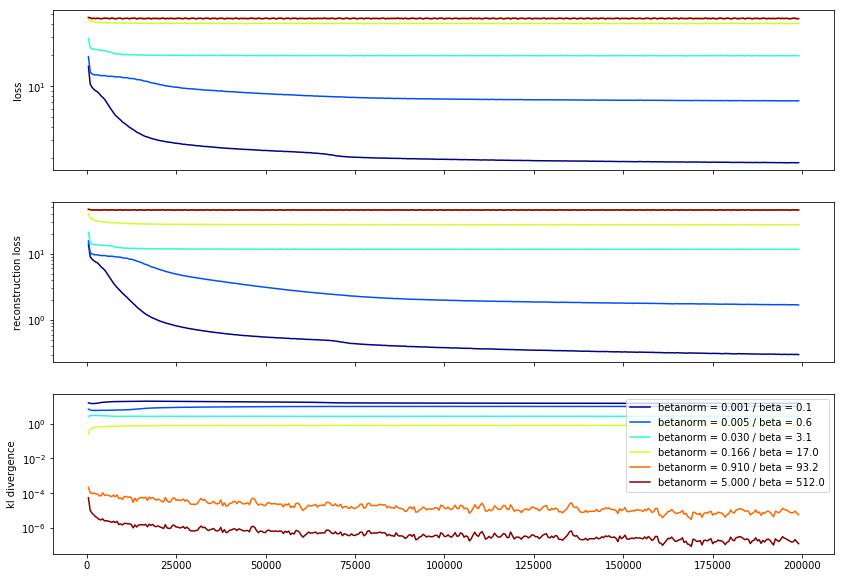

In [30]:
show_until_nth_batch = 200000
idx_lim = np.max(np.where(np.array(training_stats[ii]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(3,1,sharey=False,sharex=True, figsize=(14,10))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
for ii,nb in enumerate(normalized_beta_values):
    logged_steps = training_stats[ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[ii]['total_kld'][:idx_lim])
    
    ax[0].plot(logged_steps, recon_loss+ beta[ii] * total_kld, color=col[ii])
    ax[1].plot(logged_steps, recon_loss, color=col[ii])
    ax[2].plot(logged_steps, total_kld, color=col[ii])
    
    ax[0].set(ylabel='loss')
    ax[1].set(ylabel='reconstruction loss')    
    ax[2].set(ylabel='kl divergence')
    
    _ = [x.set(yscale='log') for x in ax]
    
    ax[2].legend(['betanorm = %0.3f / beta = %0.1f' % (x,y) for x,y in zip(normalized_beta_values,beta)], loc=1)


beta clearly modulates the trade-off between reconstruction and kl-divergence (as expected)


##### plotting reconstruction loss and kl-divergence for each beta value separately

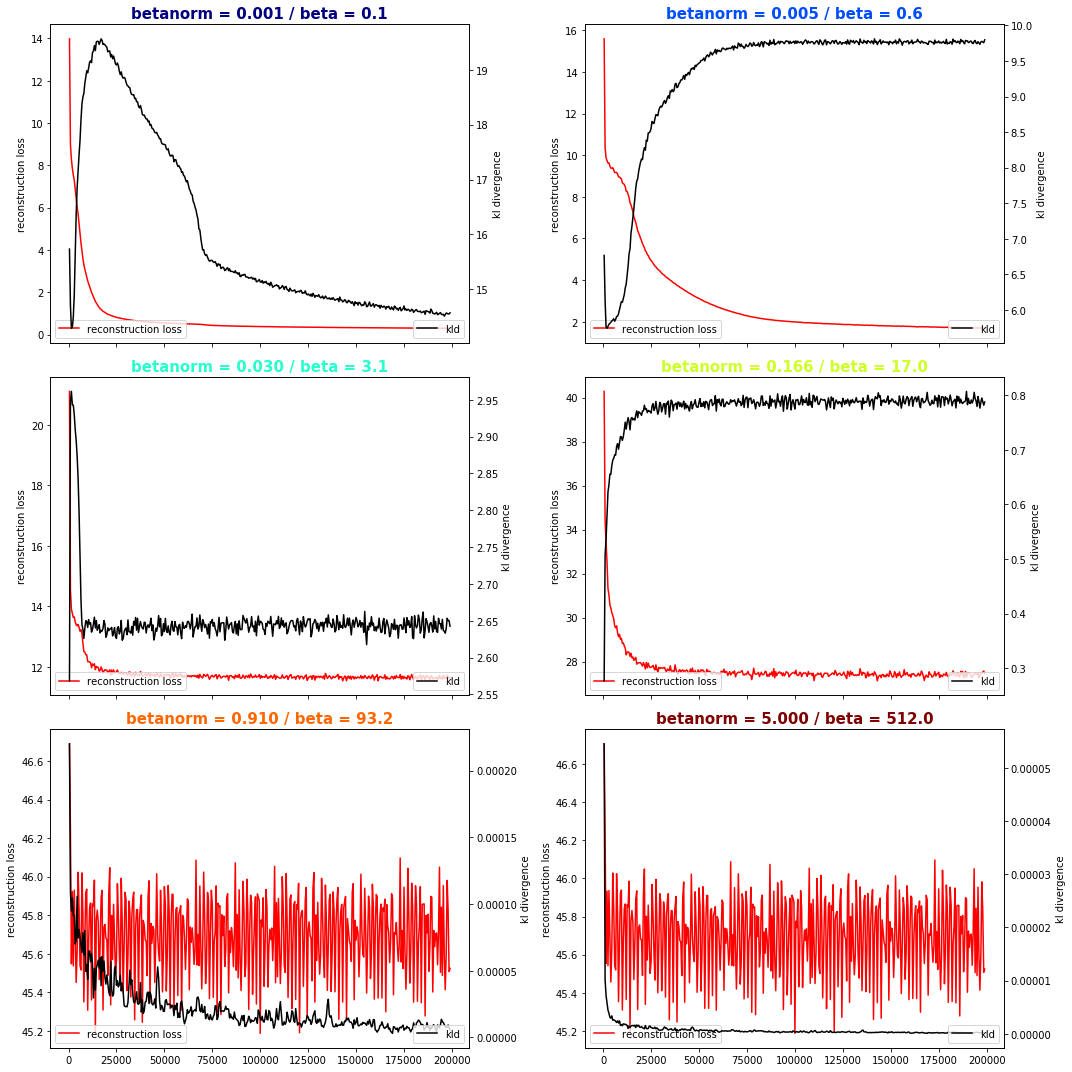

In [31]:
fig, ax = plt.subplots(3,2,sharey=False,sharex=True, figsize=(15,15))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
ax2 = list()
for ii,nb in enumerate(normalized_beta_values):
    logged_steps = training_stats[ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[ii]['total_kld'][:idx_lim])
    
    ax[ii].plot(logged_steps, recon_loss, color='r', label='reconstruction loss')
    ax2.append(ax[ii].twinx())
    
    ax2[ii].plot(logged_steps, total_kld, color='k', label='kld')
    
    ##ax[0].set(ylabel='loss')
    #ax[1].set(ylabel='reconstruction loss')    
    ax[ii].set(ylabel='reconstruction loss')
    ax2[ii].set(ylabel='kl divergence')
    plt.title('betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii]), color=col[ii], 
              fontweight='bold', fontsize = 15)
    
    ax[ii].legend(loc=3)
    ax2[ii].legend(loc=4)
    
fig.tight_layout()

some interesting training dynamics for the lowest beta (.001) -> kld increases first. then, after reconstruction loss convergeces (to almost zero), kld is reduced.

## load some data and plot reconstructions


In [32]:
ds = dSpriteBackgroundDataset(transform=transforms.Resize(32),shapetype = 'circle')

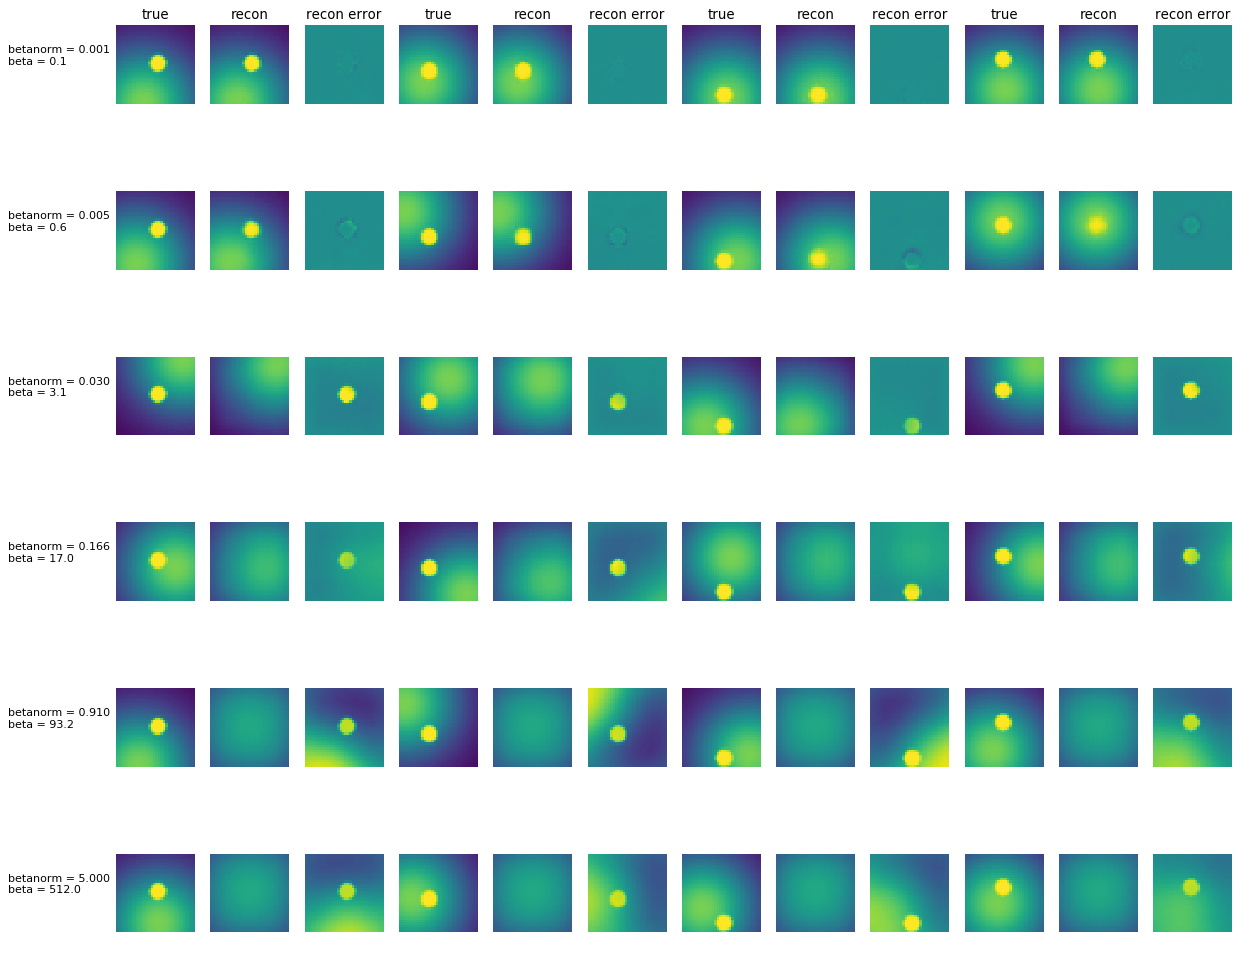

In [33]:
fig, ax = plt.subplots(len(vae),12,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = ax.flatten()
cnt = -1
n_b = len(normalized_beta_values)
img_idx = np.random.randint(1000, size=4)

for jj,nb in enumerate(normalized_beta_values): # loop across rows (different beta values)
    for ii in range(4): # loop across different samples
        
        x,label = ds[img_idx[ii]]
        x = x[np.newaxis, :, :]

        mu, logvar = vae[jj].encode(x.float())
        recon = vae[jj].decode(mu).detach()
        diff = x - recon

        cnt += 1
        ax[cnt].imshow(x.squeeze(), vmin=0, vmax=1)
        ax[cnt].axis('off')
        
        cnt += 1
        ax[cnt].imshow(recon.squeeze(), vmin=0, vmax=1)
        ax[cnt].axis('off')

        cnt += 1
        m = .5
        img = ax[cnt].imshow(diff.numpy().squeeze(), vmin=-m, vmax=m)
        ax[cnt].axis('off')
        
        if jj == 0:
            ax[cnt-2].set(title='true')
            ax[cnt-1].set(title='recon')
            ax[cnt].set(title='recon error')
        
        if ii == 0:
            pos = ax[cnt].get_position()
            fig.text(.05, pos.y0 + pos.height/2, 'betanorm = %0.3f\nbeta = %0.1f' % (normalized_beta_values[jj],beta[jj]))
    

Each row displays the true/reconstructed/error for four samples with one beta.

- Interestingly, with increased beta, the circle object gets lost / is not captured by the VAE any more. 

- At very high beta values, the gaussian background blob is always reconstructed at the same (central) location. This is the case, when q(z|x) is almost equal to p(z), hence indepndent of x. The best "reconstruction" (to minimize reconstruction loss) is the mean image. -> probably, what we see in the high-beta reconstruction case is therefore not a central Gaussian but the average of all circle positions. As circles are constrained to not touch the image borders, this mean image looks like a centered Gaussian.